# Exercise: Predicting Lorenz system using RC

2020/11/04 - skim0119

[paper](https://arxiv.org/abs/1710.07313) - Section III example 1

### Contains
- Lorenz 1963 system define
- Sparse random Erdos-Renyi network
- Tikhonov Regularized Regression (with sklearn)
- RC implemented using nengo

### Difference with original paper
- Third coordinate (z) is not symmetrical.

## Table of Contents
* [1. Lorenz 1963 System](#1-bullet)
* [2. Sparse random Erdos-Renyi network](#2-bullet)
* [3a. Reservoir Computing without Nengo](#3a-bullet)
* [3b. Reservoir Computing using Nengo](#3b-bullet)
* [4. Training with Tikhonov Regularized Regression](#4-bullet)
* [5. Evaluation - Predict Future Data](#5-bullet)

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as sps
import scipy.stats as spst
from sklearn.linear_model import Ridge

import nengo

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

### Hyperparameters

In [2]:
# Random Seed
seed = 100

# Lorenz System Parameters
v_init = np.array([0.1,0.1,0.1])
dt = 0.02
T_total = 125
T_train = 100
num_train = int(T_train/dt)

# RC model Parameters
num_reservoir_neurons = 512  # Dr
spectral_radius = 1.2  # rho

# Training Loss Hyperparameter
beta = 1e-1

### Functions

In [36]:
# Plot
def plot_1(v_out, v_train, dt, draw_diff=True):
    assert v_out.shape == v_train.shape
    length = v_out.shape[0]
    time = np.arange(length)*dt
    
    print(f'2-norm error : {np.linalg.norm(v_out-v_train, 2)}')
    print(f'inf-norm error : {np.linalg.norm(v_out-v_train, np.inf)}')

    # plot 3d trajectory
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121, projection=Axes3D.name)
    ax.plot(*v_out.T, lw=0.5)
    ax.set_title('Simulated')
    ax = fig.add_subplot(122, projection=Axes3D.name)
    ax.plot(*v_train.T, 'tab:orange', lw=0.5)
    ax.set_title('Target')

    # plot v_out
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(331)
    ax.plot(time, v_out[:,0])
    ax.set_title('x')
    ax.set_ylabel('Simulated')
    ax = fig.add_subplot(334)
    ax.plot(time, v_train[:,0], 'tab:orange')
    ax.set_ylabel('Target')
    ax = fig.add_subplot(332)
    ax.plot(time, v_out[:,1])
    ax.set_title('y')
    ax = fig.add_subplot(335)
    ax.plot(time, v_train[:,1], 'tab:orange')
    ax = fig.add_subplot(333)
    ax.plot(time, v_out[:,2])
    ax.set_title('z')
    ax = fig.add_subplot(336)
    ax.plot(time, v_train[:,2], 'tab:orange')
    
    # plot diff
    if draw_diff:
        fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot(337)
        ax.plot(time, v_out[:,0] - v_train[:,0], 'k')
        ax.set_ylabel('Difference')
        ax.set_xlabel('time')
        ax = fig.add_subplot(338)
        ax.plot(time, v_out[:,1] - v_train[:,1], 'k')
        ax.set_xlabel('time')
        ax = fig.add_subplot(339)
        ax.plot(time, v_out[:,2] - v_train[:,2], 'k')
        ax.set_xlabel('time')

## 1. Lorenz 1963 System <a class="anchor" id="1-bullet"></a>

In [4]:
def lorenz(x, y, z, s=10, r=28, b=8.0/3.0):
    ''' Lorenz Iterator
    Parameters
    ----------
       x, y, z: a point in three dimensional space
       s, r, b: lorenz attractor
    Returns
    -------
       x_dot, y_dot, z_dot: partial derivatives
    '''
    x_dot = s*(y - x)
    y_dot = x * (r - z) - y
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot

In [5]:
def iterator(func, initial, dt=0.02, T=100, **kwargs):
    time = 0
    while time < T:
        v_dot = lorenz(*initial, **kwargs)
        vs = initial + np.array(v_dot) * dt
        time += dt
        yield initial, vs
        initial = vs

In [17]:
# Data Generate (us: input, vs: output)
us = []
vs = []
for u, v in iterator(lorenz, v_init, dt=dt, T=T_total):
    us.append(u)
    vs.append(v)
us = np.array(us)
vs = np.array(vs)

# Rescale factor
uscale = 1.0/np.abs(us).max()
vscale = 1.0/np.abs(vs).max()

Text(0, 0.5, 'x')

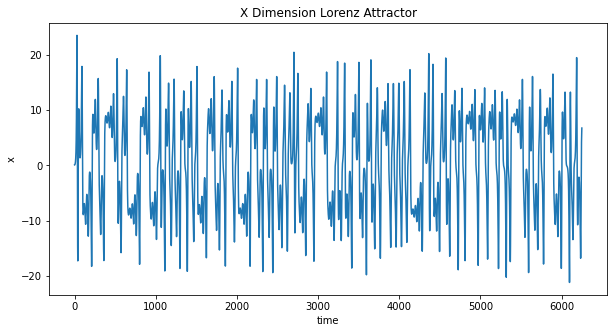

In [7]:
plt.figure(figsize=(10,5))
plt.plot(us[:,0])
plt.title('X Dimension Lorenz Attractor')
plt.xlabel('time')
plt.ylabel('x')

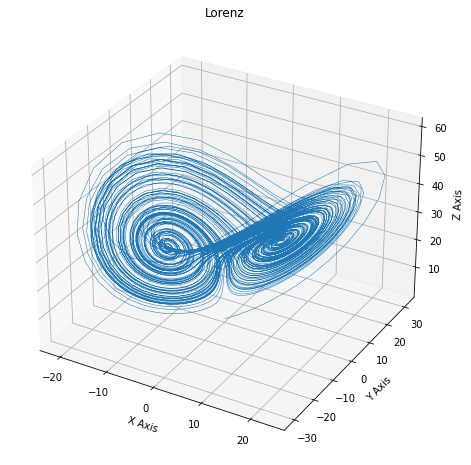

In [9]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')

ax.plot(*us.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")

ax.set_zlabel("Z Axis")
ax.set_title("Lorenz")

plt.show()

## 2. Sparse random Erdos-Renyi network <a class="anchor" id="2-bullet"></a>

In [125]:
def generate_innerconnection(n, alpha=(-1,1), seed=0, degree=6, spectral_radius=0.9):
    ''' Generate Inner-connection Adjacency Matrix
    Design to generate sparsly connected graph according
    to Erdos-Renyi (ER) Random Graph
    
    Note
    ----
    Density of the graph means the density of connections.
    In scipy sparse package, density means density of non-zero elements.
    
    Parameters
    ----------
    n : number of neuron in reservoir
    alpha : lower/upper bound (equivalent to 'a' in the paper)
        Note that the bound will be re-adjusted to fit spectral radius.
    seed : random seed
    degree : ER graph degree (N*density=degree)
    spectral_radius : spectral radius (equivalent to 'rho' in the paper)
    '''
    
    if isinstance(alpha, float) or isinstance(alpha, int):
        alpha = (-alpha, alpha)
    
    rho = 0.05#min(degree / n, 1.0)  # Density (clip [0,1))
    
    # Random Seed
    np_random = np.random.RandomState(seed)  # Random Generator
    
    A = np_random.rand(n,n) - 0.5
    A[np_random.rand(*A.shape) < 1-rho] = 0
    A = A * spectral_radius / np.abs(np.linalg.eigvals(A)).max()
    return A
    
    #(TODO)
    # Generate Adjacency (with weights)
    rvs = spst.uniform(alpha[0], alpha[1]).rvs
    A = sps.random(n, n, density=rho, random_state=np_random, data_rvs=rvs)
    
    # Fit Spectral Radius
    E, _ = sps.linalg.eigs(A)
    A *= spectral_radius / np.abs(E).max()  # (TODO) I'm not sure this is 'sparse-friendly' way
    
    return A

def generate_coupler(n, m, alpha=(-1,1), seed=0):
    if isinstance(alpha, float) or isinstance(alpha, int):
        alpha = (-alpha, alpha)
    np_random = np.random.RandomState(seed)
    coupler = np_random.uniform(alpha[0], alpha[1], (n, m))
    return coupler

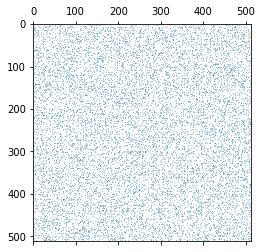

In [126]:
A = generate_innerconnection(num_reservoir_neurons, seed=seed, spectral_radius=spectral_radius)
#print(f'density : {A.nnz / np.prod(A.shape)}')
plt.spy(A, markersize=.1)

In [15]:
W_in = generate_coupler(num_reservoir_neurons, 3, alpha=1, seed=seed)  # Dr x D

## 3.a Reservoir Computing without Nengo <a class="anchor" id="3a-bullet"></a>

### Data Processing

In [142]:
# Training Dataset
u_train = us[:num_train] * uscale
v_train = vs[:num_train] * vscale

In [47]:
# Run reservoir
r = np.zeros(num_reservoir_neurons) # Initial state
r_next = []
for u in u_train:
    r = np.tanh(W_in@u + A.dot(r))
    r_next.append(r)
r_next = np.asarray(r_next)

In [48]:
# Build decoder
P = np.linalg.pinv(r_next)
W_out = np.dot(P, v_train).T
decode_1 = lambda r: r@W_out.T

v_out  = decode_1(r_next)
print("training error:");
print(np.sqrt(np.mean((v_out - v_train)**2)))

training error:
3.515552217059032e-05


In [49]:
clf = Ridge(alpha=beta, fit_intercept=False)
clf.fit(r_next, v_train)
print(f'score (R^2) : {clf.score(r_next, v_train)}')
decode_2 = lambda r: clf.predict(r)

v_out  = decode_2(r_next)
print("training error:");
print(np.sqrt(np.mean((v_out - v_train)**2)))

score (R^2) : 0.9999945988877933
training error:
0.00034003741116222835


Training:
2-norm error : 0.029614506037076088
inf-norm error : 0.00827740978288416


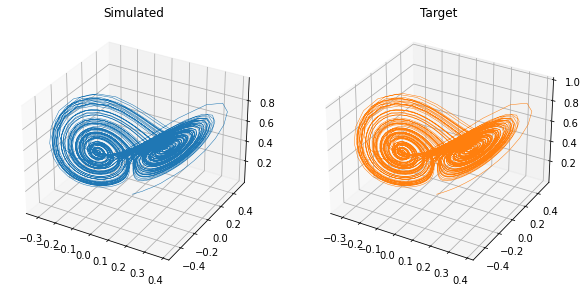

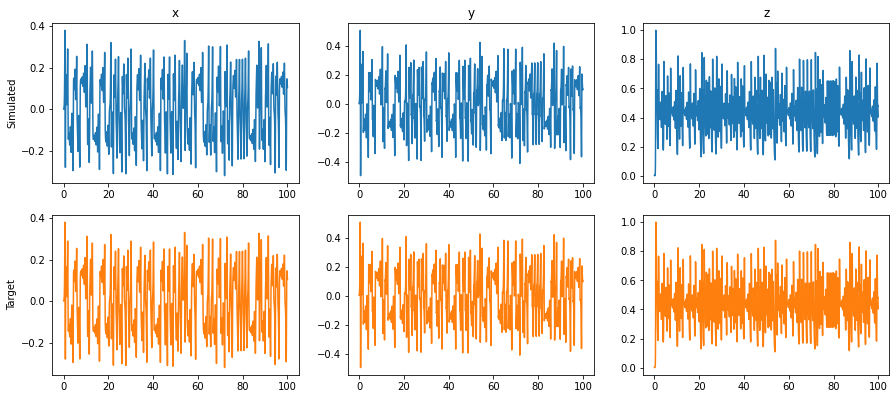

In [50]:
print('Training:')
plot_1(v_out, v_train, dt)

In [51]:
# Prediction
v_t = W_out@r  # Last state
v_out = []
v_test = vs[num_train:]
for _ in v_train:
    r = np.tanh(W_in@v_t + A.dot(r))
    v_t = decode_1(r)
    v_out.append(v_t)
v_out = np.asarray(v_out) / vscale # rescale

Evaluate:
2-norm error : 527.277866651805
inf-norm error : 82.59193052565483


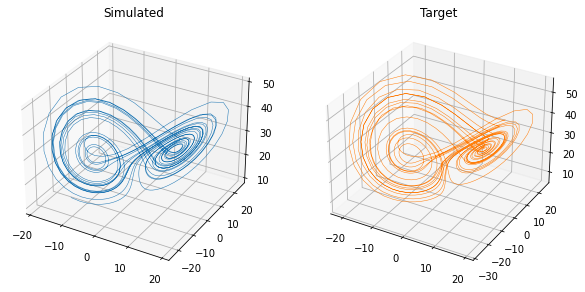

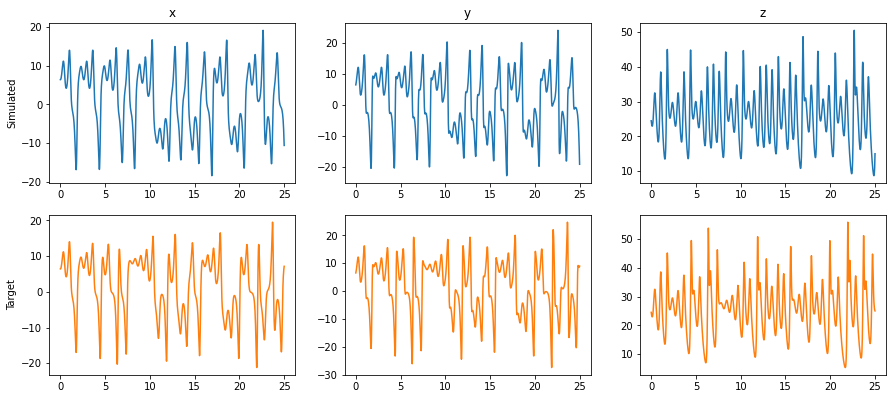

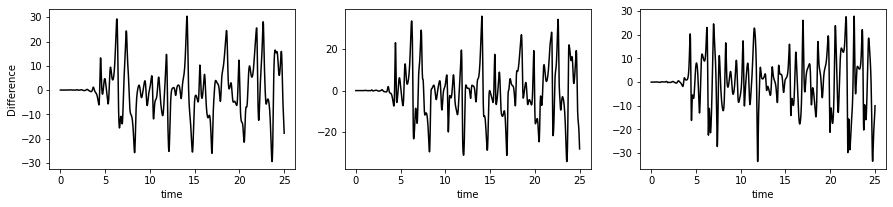

In [52]:
# Plot
print('Evaluate:')
plot_1(v_out, v_test, dt)

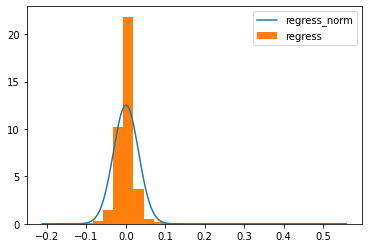

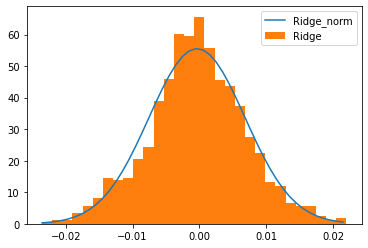

In [61]:
# Debug: W_out distribution should resemble normal (Gaussian)
e = np.eye(num_reservoir_neurons)
w_out_1 = (decode_1(e)).ravel()  # regression
w_out_2 = (decode_2(e)).ravel()  # Ridge

# draw histogram
plt.figure()
plt.hist(w_out_1, density=True, bins=30, label='regress')
x = np.arange(w_out_1.min(), w_out_1.max(), 0.001)
y = sp.stats.norm.pdf(x, w_out_1.mean(), w_out_1.std())
plt.plot(x,y,label='gaussian')
plt.legend()

plt.figure()
plt.hist(w_out_2, density=True, bins=30, label='Ridge')
x = np.arange(w_out_2.min(), w_out_2.max(), 0.001)
y = sp.stats.norm.pdf(x, w_out_2.mean(), w_out_2.std())
plt.plot(x,y,label='gaussian')
plt.legend()

## 3.b Reservoir Computing using Nengo <a class="anchor" id="3b-bullet"></a>

### Data Preperation

In [178]:
feedback = [np.zeros(3)]  # (TODO) - remove global variale. find better way
def input_func(time):
    if time <= T_train:
        return u_train[int(time/dt)-1]
    else:
        return np.zeros(3)

In [116]:
def input_func(t, x):
    if t < T_train: 
        u_dot = lorenz(*x)
        us = x + np.array(u_dot) * dt
        return us * uscale
    else:
        return np.zeros(3)

def tanh(t, x):
    return np.tanh(x)

### RC Model

In [181]:
network = nengo.Network(label='Lorenz63 Predictor')
with network:
    in_node = nengo.Node(input_func, size_out=3)
    
    reservoir = nengo.Ensemble(n_neurons=num_reservoir_neurons, dimensions=3)
    conn_in = nengo.Connection(in_node, reservoir, synapse=0, transform=W_in)  # Decode
    conn_res = nengo.Connection(reservoir.neurons, reservoir.neurons,
                                synapse=0.1, transform=A)
    
    #activation_node = nengo.Node(tanh, size_in=num_reservoir_neurons, size_out=num_reservoir_neurons)
    #conn_tanh = nengo.Connection(reservoir.neurons, activation_node)
    state_probe = nengo.Probe(reservoir.neurons, synapse=0.1, label='r')
    input_probe = nengo.Probe(in_node)

ValidationError: init: Shape of initial value (512, 3) does not match expected shape (3, 3)

### Pre-trained Simulation

In [180]:
with nengo.Simulator(network, dt=dt, optimize=False) as sim:
    for i in range(10):
        sim.step()
        u = u_train[i]
        print(u@W_in.T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

0.02
[-8.21193373e-04 -1.71204104e-03  4.31488023e-04  5.68432225e-04
 -3.19338366e-03  1.49618785e-03  7.12174968e-05  1.92196225e-03
 -3.06220275e-03 -1.41335328e-03 -6.22120418e-04 -6.18768866e-04
  1.39636876e-03  1.45513654e-03 -2.22589753e-03  2.08756042e-04
  1.98509898e-03  1.11092266e-03 -2.02923522e-03 -2.30461559e-03
  3.20438837e-04  1.69225017e-03 -4.74992175e-04 -2.49992748e-03
  1.93309396e-03  5.49148404e-04 -1.41041209e-03  3.51685599e-04
  1.16791893e-04  6.52053114e-04 -1.78673871e-03 -2.31236097e-04
 -1.30932835e-03  2.31594536e-03  3.78906714e-04  3.13108398e-03
 -1.07987407e-03  1.74070366e-03 -1.22712570e-03 -2.31124309e-04
  7.84536174e-04 -1.98003813e-03 -7.83967234e-04 -2.23604661e-03
 -1.58594859e-03  1.15350958e-03  1.92849013e-03 -4.47909361e-04
  2.21314630e-03 -1.12374568e-03 -9.86811007e-04  4.22960776e-05
 -3.92207538e-04 -1.68053538e-03  2.00769941e-03 -3.47351604e-05
 -6.59951262e-05 -2.43144479e-03  2.65226437e-03 -5.42930625e-04
  1.47011161e-03 -3.

In [179]:
sim.data[state_probe]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 9.06346235,  9.06346235,  9.06346235, ...,  9.06346235,
         0.        ,  0.        ],
       [16.4839977 , 16.4839977 ,  7.42053535, ...,  7.42053535,
         0.        ,  0.        ],
       ...,
       [28.60668946,  6.06412386,  2.7298624 , ...,  2.7298624 ,
         0.        ,  0.        ],
       [23.4211764 ,  4.9648847 ,  2.2350223 , ...,  2.2350223 ,
         0.        ,  0.        ],
       [19.17563739,  4.06490379,  1.82988149, ...,  1.82988149,
         0.        ,  0.        ]])

In [161]:
# Pre-trained Simulation
with nengo.Simulator(network, dt=dt, optimize=False) as sim:
    sim.run(T_train)
r_next = sim.data[state_probe]

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

## 4. Training with Tikhonov Regularized Regression <a class="anchor" id="4-bullet"></a>

In [162]:
clf = Ridge(alpha=beta, fit_intercept=False)
clf.fit(r_next, v_train)
print(f'score (R^2) : {clf.score(r_next, v_train)}')
decode_2 = lambda r: clf.predict(r)

v_out  = decode_2(r_next)
print("training error:");
print(np.sqrt(np.mean((v_out - v_train)**2)))

score (R^2) : 0.6001103324279481
training error:
0.0915656013493746


After Training:
2-norm error : 8.46045364801322
inf-norm error : 0.9516641054511922


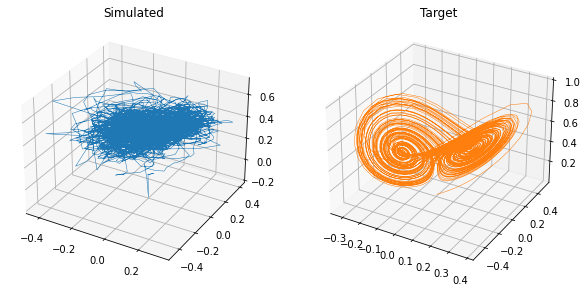

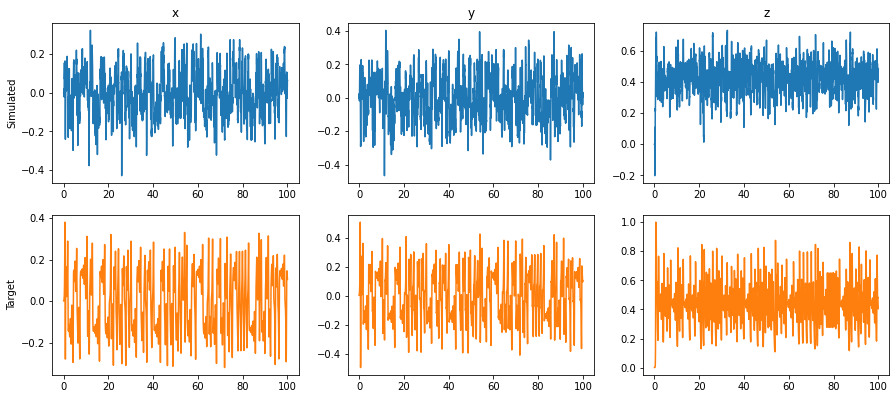

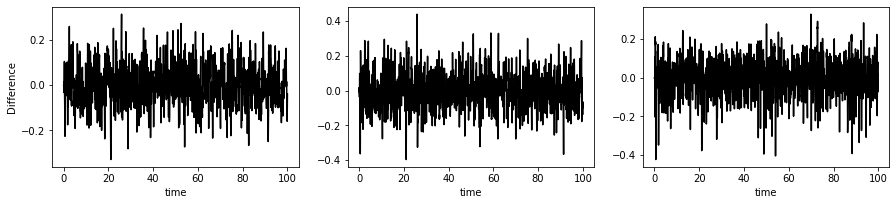

In [163]:
# Plot
print('After Training:')
plot_1(v_out, v_train, dt)

## 5. Evaluation - Predict Future Data <a class="anchor" id="5-bullet"></a>

In [17]:
v_out = []
with nengo.Simulator(network, dt=dt, optimize=False) as sim:
    for _ in range(int(T_total/dt)+1):
        sim.step()
        Ar = sim.data[state_probe][-1]
        r_next = np.tanh(Ar)
        v = clf.predict(r_next[None,:])
        v_out.append(v[0])
        feedback[0] = v
v_out = np.array(v_out)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

After Training - Evaluation:
2-norm error : 1211.849259693866
inf-norm error : 131.88082870602915


Text(0.5, 0, 'time')

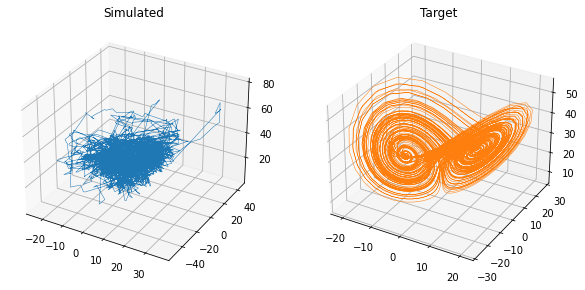

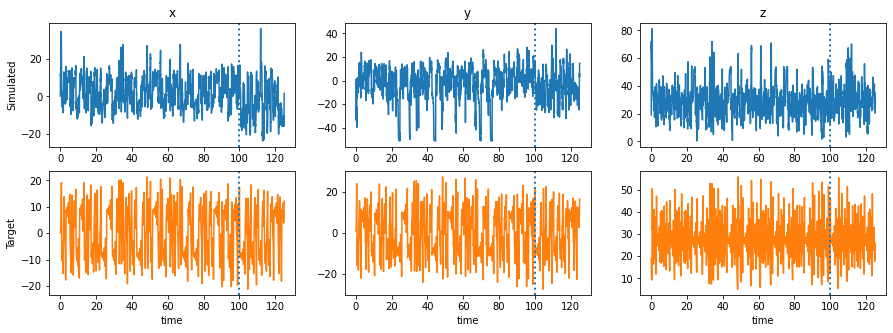

In [18]:
# Plot
print('After Training - Evaluation:')
print(f'2-norm error : {np.linalg.norm(v_out-vs, 2)}')
print(f'inf-norm error : {np.linalg.norm(v_out-vs, np.inf)}')

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection=Axes3D.name)
ax.plot(*v_out.T, lw=0.5)
ax.set_title('Simulated')
ax = fig.add_subplot(122, projection=Axes3D.name)
ax.plot(*vs.T, 'tab:orange', lw=0.5)
ax.set_title('Target')

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(231)
ax.plot(sim.trange(), v_out[:,0])
ax.axvline(T_train, lw=2, ls='dotted')
ax.set_title('x')
ax.set_ylabel('Simulated')
ax = fig.add_subplot(234)
ax.plot(sim.trange(), vs[:,0], 'tab:orange')
ax.axvline(T_train, lw=2, ls='dotted')
ax.set_ylabel('Target')
ax.set_xlabel('time')
ax = fig.add_subplot(232)
ax.plot(sim.trange(), v_out[:,1])
ax.axvline(T_train, lw=2, ls='dotted')
ax.set_title('y')
ax = fig.add_subplot(235)
ax.plot(sim.trange(), vs[:,1], 'tab:orange')
ax.axvline(T_train, lw=2, ls='dotted')
ax.set_xlabel('time')
ax = fig.add_subplot(233)
ax.plot(sim.trange(), v_out[:,2])
ax.axvline(T_train, lw=2, ls='dotted')
ax.set_title('z')
ax = fig.add_subplot(236)
ax.plot(sim.trange(), vs[:,2], 'tab:orange')
ax.axvline(T_train, lw=2, ls='dotted')
ax.set_xlabel('time')

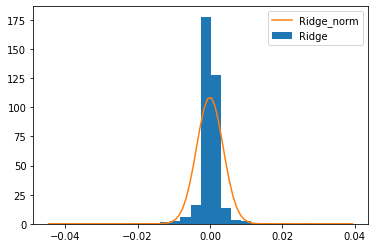

In [164]:
# Debug: W_out distribution should resemble normal (Gaussian)
e = np.eye(num_reservoir_neurons)
W_out = (decode_2(e)).ravel()  # Ridge

# draw histogram
plt.figure()
plt.hist(W_out, density=True, bins=30, label='Ridge')
x = np.arange(W_out.min(), W_out.max(), 0.001)
y = sp.stats.norm.pdf(x, W_out.mean(), W_out.std())
plt.plot(x,y,label='Ridge_norm')
plt.legend()